<a href="https://colab.research.google.com/github/Vaani64/Bike-Network-Flow-Prediction/blob/main/Bike_Network_Flow_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
import calendar
import collections

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
import plotly.graph_objects as go

import networkx as nx
import community as community_louvain
from operator import itemgetter

import folium
from folium import plugins

# Custom Colors
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"

In [ ]:
dataframe = pd.read_csv("/content/database.csv", low_memory=False)
dataframe.head()

,departure,return,departure_id,departure_name,return_id,return_name,distance (m),duration (sec.),avg_speed (km/h),departure_latitude,departure_longitude,return_latitude,return_longitude,Air temperature (degC)
0,2020-03-23 06:09:44,2020-03-23 06:16:26,86,Kuusitie,111.0,Esterinportti,1747.0,401.0,0.261397,60.195245,24.901900,60.197572,24.926781,0.9
1,2020-03-23 06:11:58,2020-03-23 06:26:31,26,Kamppi (M),10.0,Kasarmitori,1447.0,869.0,0.099908,60.168610,24.930537,60.165017,24.949473,0.9
2,2020-03-23 06:16:29,2020-03-23 06:24:23,268,Porolahden koulu,254.0,Agnetankuja,1772.0,469.0,0.226695,60.195540,25.053581,60.187234,25.036412,0.9
3,2020-03-23 06:33:53,2020-03-23 07:14:03,751,Vallipolku,106.0,Korppaanmäentie,7456.0,2406.0,0.185935,60.227827,24.819614,60.203474,24.898930,0.9
4,2020-03-23 06:36:09,2020-03-23 07:04:10,62,Länsisatamankatu,121.0,Vilhonvuorenkatu,7120.0,1679.0,0.254437,60.158928,24.909692,60.186463,24.967872,0.9


In [ ]:
print(dataframe.dtypes)


departure                  object
return                     object
departure_id                int64
departure_name             object
return_id                 float64
return_name                object
distance (m)              float64
duration (sec.)           float64
avg_speed (km/h)          float64
departure_latitude        float64
departure_longitude       float64
return_latitude           float64
return_longitude          float64
Air temperature (degC)    float64
dtype: object


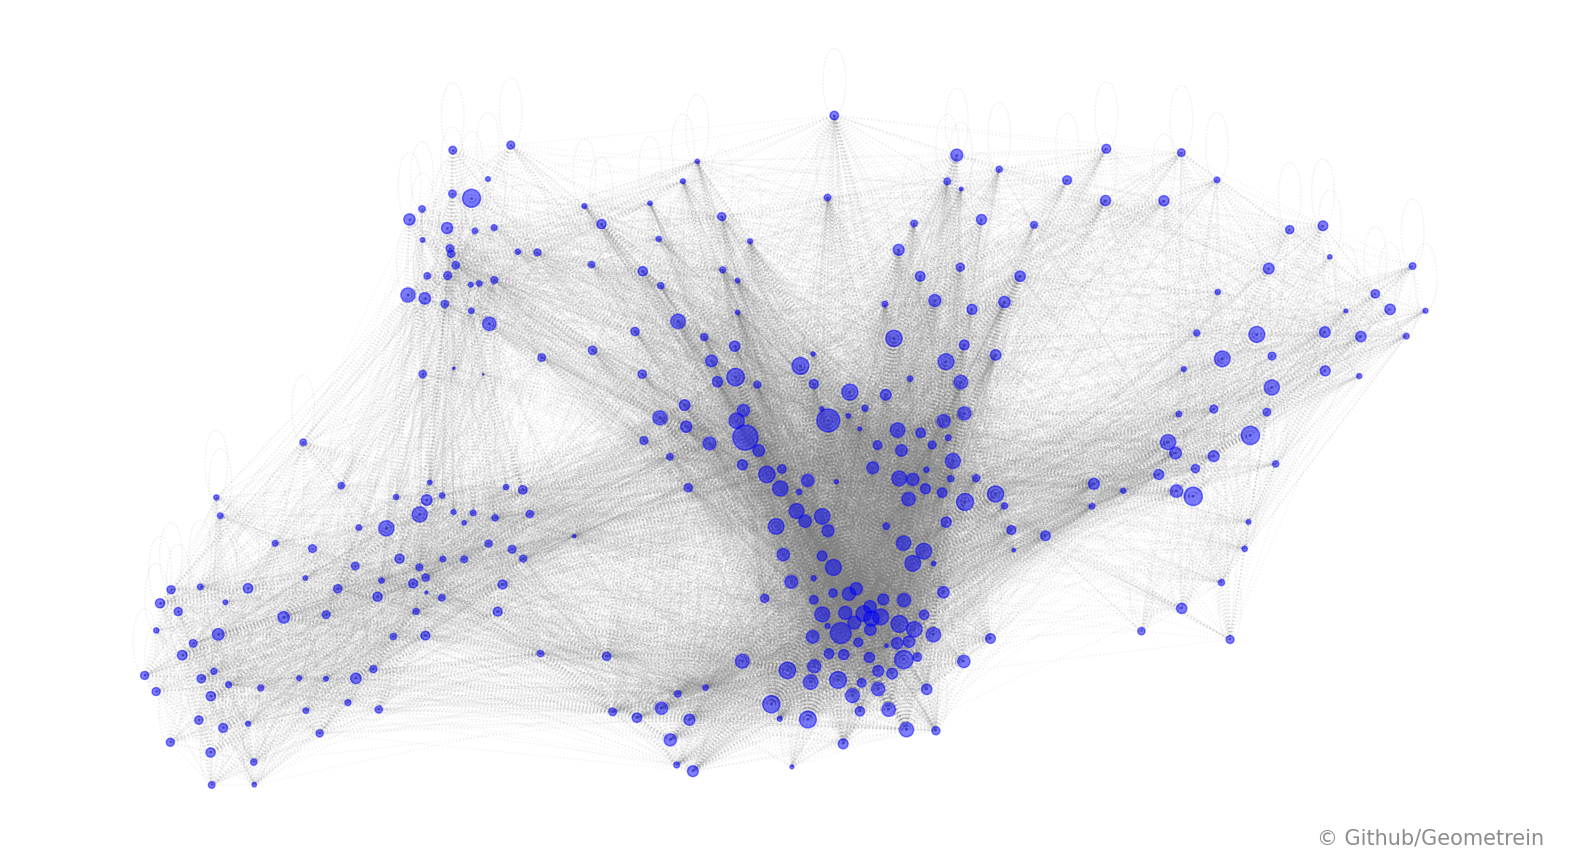

In [ ]:
def bikeNetwork(dataframe, year=2020):
    """
    This function plots the City bike network with node sizes illustrating station popularity.
    """
    # Convert 'departure' to datetime if it is not already
    if not pd.api.types.is_datetime64_any_dtype(dataframe['departure']):
        dataframe['departure'] = pd.to_datetime(dataframe['departure'], errors='coerce')

    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]  # Now this should work
    df.dropna(inplace=True)  # Drop rows with NaT in 'departure'

    # Graphs
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration (sec.)','distance (m)'])

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Positions
    stations = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stations.set_index('name', inplace=True)
    stations["pos"] = list(zip(stations["longitude"].astype(float), stations["latitude"].astype(float)))
    pos = stations.to_dict()['pos']

    # Map "pos" attribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos'), node_color='blue', alpha=0.5,
                           node_size=(df['departure_name'].value_counts()/15).tolist())
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos'), edge_color='grey', style="dotted", alpha=0.1, arrows=False)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)

    return G

# Now call the function with your DataFrame
G = bikeNetwork(dataframe)


In [ ]:
import networkx as nx


In [ ]:
import networkx as nx
print(nx.__version__)


3.4.2


In [ ]:
pip install --upgrade networkx


In [ ]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 335
Number of edges: 18488


In [ ]:
def networkStats(G):
    """
    This function prints the basic properties of the City bike network.
    """
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())
    density = nx.density(G)
    print("Network density:", density)
    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')

    sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
    print("\nTop 5 nodes by degree:\n")
    for d in sorted_degree[:5]:
        print(d)

    betweenness_dict = nx.betweenness_centrality(G)
    eigenvector_dict = nx.eigenvector_centrality(G)

    sorted_betweenness = sorted(betweenness_dict.items(), key=lambda x: x[1], reverse=True)

    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)

# Call the function with your graph
networkStats(G)


Number of nodes: 335
Number of edges: 18488
Network density: 0.3304674233622308
Triadic closure: 0.6604244817204891

Top 5 nodes by degree:

('Haukilahdenkatu', 240)
('Kalasatama (M)', 205)
('Paciuksenkaari', 200)
('Ympyrätalo', 198)
('Laajalahden aukio', 198)

Top 5 nodes by betweenness centrality:

('Haukilahdenkatu', 0.06642541666973545)
('Paciuksenkaari', 0.012035975989968384)
('Lauttasaaren ostoskeskus', 0.011425738890055688)
('Kalasatama (M)', 0.011366698029521649)
('Laajalahden aukio', 0.010308836422529933)


In [ ]:
def mapPlot(dataframe, year = 2020):
    """
    This function prints an interactive bubble plot by destination locations for a given year.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    #df = df[:1000]
    df.dropna(inplace=True)
    df['freq'] = df.groupby('departure_name')['departure_name'].transform('count')
    #print(df.isna().sum())
    df["name"] = df["departure_name"]
    df = df[["name", "freq"]]
    df = df.drop_duplicates(subset=['name'])
    freq_dict = dict(zip(df.name, df.freq))

    df_stations = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv", index_col=False)
    df_stations = df_stations[df_stations["latitude"]<=60.254011]
    #print(df_stations.head())
    df_stations['freq']= df_stations['name'].map(freq_dict)
    #print(df_stations.head(), df_stations.isna().sum(), len(df_stations))
    df_stations["freq_adj"] = df_stations['freq']/(df_stations['freq'].median()/3)
    df_stations.fillna(1, inplace=True)
    df_stations.dropna(inplace=True)

    # Map
    hel_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)

    for index, row in df_stations.iterrows():
        folium.CircleMarker([row['latitude'],row['longitude']],
                        radius=row["freq_adj"],
                        popup=row['freq'],
                        color="#eab544",
                        fill_color="#eab544",
                    ).add_to(hel_map)

    display(hel_map)

# function call is commented for performance reasons
mapPlot(dataframe)

In [ ]:
def heatMapPlot(dataframe, year = 2020):
    """
    This function prints an interactive heatmap by destination locations for a given year.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]

    df.dropna(inplace=True)
    df['freq'] = df.groupby('departure_name')['departure_name'].transform('count')

    # Map
    hel_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)

    stationArr = df[['departure_latitude', 'departure_longitude']].to_numpy()
    hel_map.add_child(plugins.HeatMap(stationArr, radius=15))

    display(hel_map)

# function call is commented for performance reasons
#heatMapPlot(dataframe)

Network Centrality Measures

<ipython-input-16-5e5f3ae08d40>:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


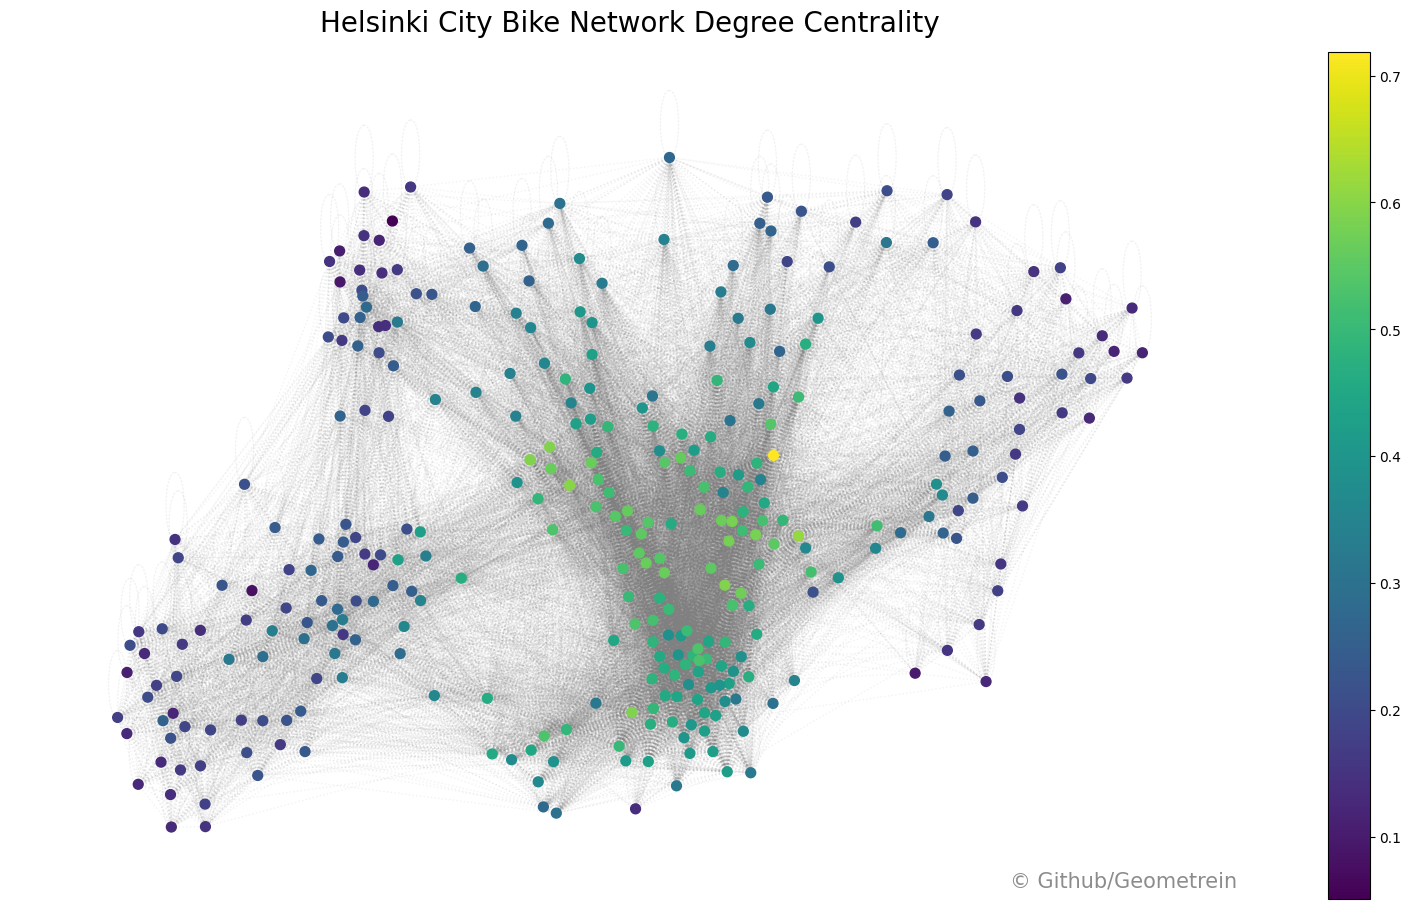

In [ ]:
def centralityDegree(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.degree_centrality(G)
    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Degree Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


# function call is commented for performance reasons
centralityDegree(G)

In [ ]:
def centralityDegreeInteractive(G):
    """
    This function plots an interactive network with colorcoded node degrees.
    """
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        opacity=0.4,
        line=dict(width=0.5, color='#888', dash='dot'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='Blues',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(thickness=15,title='Node Connections',xanchor='left',titleside='right'),
            line_width=1))

    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append('Number of connections: '+str(len(adjacencies[1])))

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    width=800,
                    height=500,
                    title='Helsinki City Bike Network 2020',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    paper_bgcolor='rgba(255,255,255,0)',
                    plot_bgcolor='rgba(255,255,255,1)',
                    annotations=[ dict(
                        text="Helsinki",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 )],
                    xaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
                    yaxis=dict(showgrid=True, zeroline=False, showticklabels=True))
                    )

    fig.show()

# function call is commented for performance reasons
#centralityDegreeInteractive(G)

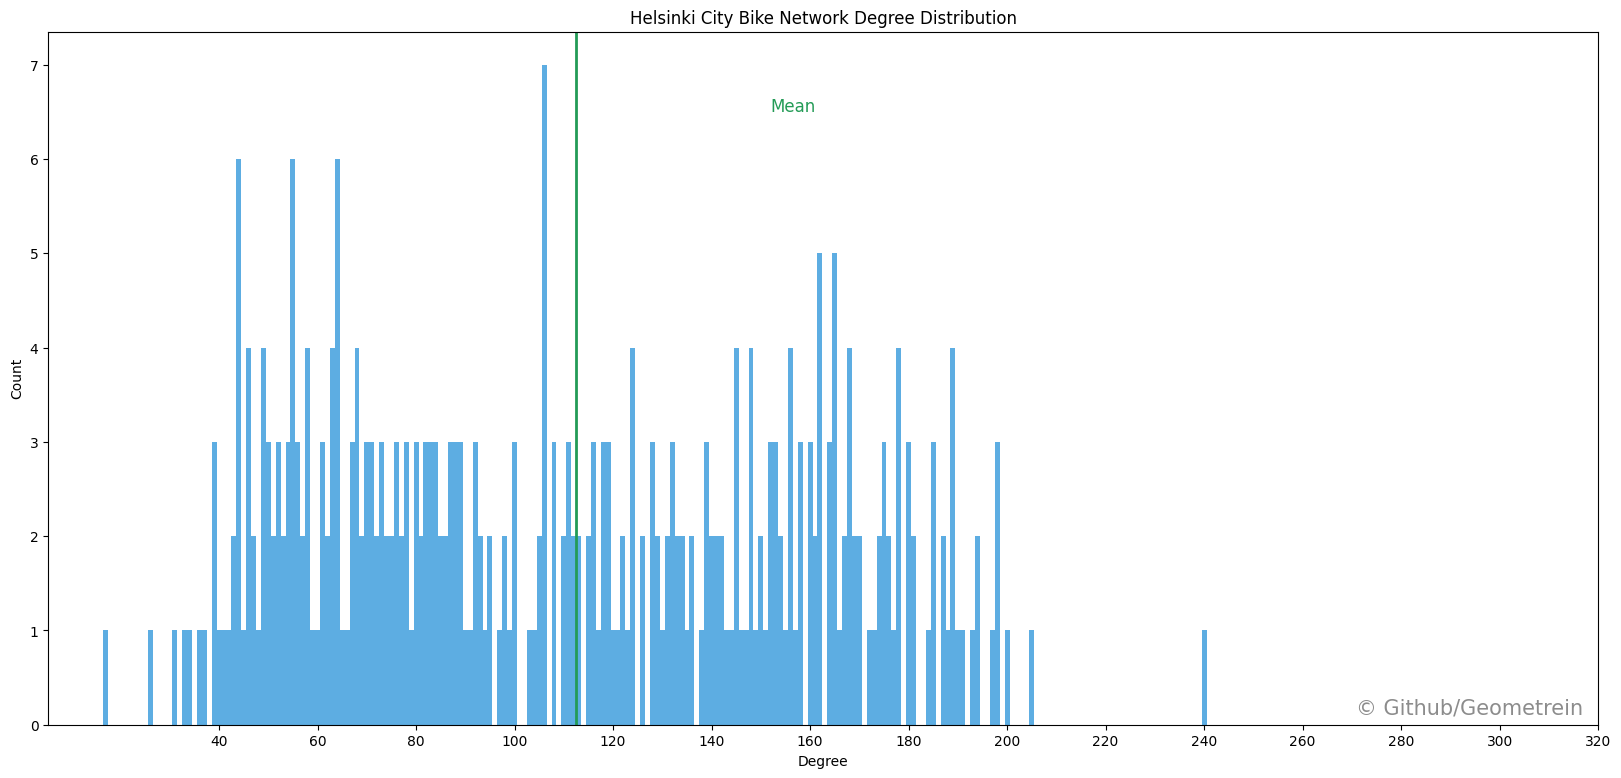

In [ ]:
def centralityDegreeDist(G):
    """
    Centrality degree distribution
    """
    # Degree
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    # Figure
    fig, ax = plt.subplots(figsize=(20,9))
    plt.bar(deg, cnt, width=1, color=BLUE)
    plt.axvline(x = sum(deg)/len(deg), color=GREEN, linestyle='-', linewidth=2) # Degree Mean
    #plt.axvline(x = np.median(deg), color="blue", linestyle='-', linewidth=1) # Degree Median

    # Labeling
    plt.title("Helsinki City Bike Network Degree Distribution")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.text(x= 152,y=6.5, s="Mean", color = GREEN, fontsize= 12)
    ax.set_xticks(range(40,340,20))

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()

centralityDegreeDist(G)


In [ ]:
def topStationsByDegree(G, top_n=10):
    """
    This function returns the top stations by degree centrality.
    """
    # Get degree dictionary
    degree_dict = dict(G.degree())

    # Sort the stations by degree
    sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

    # Extract the top N stations
    top_stations = sorted_degree[:top_n]

    print("Top {} stations by degree centrality:\n".format(top_n))
    for station, degree in top_stations:
        print(f"{station}: {degree} connections")

# Call the function to get the top stations
topStationsByDegree(G, top_n=10)


Top 10 stations by degree centrality:

Haukilahdenkatu: 240 connections
Kalasatama (M): 205 connections
Paciuksenkaari: 200 connections
Ympyrätalo: 198 connections
Laajalahden aukio: 198 connections
Huopalahdentie: 198 connections
Itämerentori: 197 connections
Fleminginkatu: 194 connections
Sörnäinen (M): 194 connections
Brahen kenttä: 193 connections


The fact that Haukilahdenkatu station is at the top of this list suggests that a large number of citizens from different districts make regular trips to and from this station. This could potentially mean that this station is either next to a large transportation hub or an important point of interest. Quick google search will reveal that it's located across the street from a large educational institution and a work rehabilitation centre. This explains both the regularity of the trips and the inflow of people from different suburban areas.

In [ ]:
def averageDegree(G):
    """
    This function calculates and prints the average degree of nodes in the graph.
    """
    # Calculate the degree of each node
    degree_sequence = [d for n, d in G.degree()]

    # Calculate the average degree
    average_degree = sum(degree_sequence) / len(degree_sequence) if degree_sequence else 0

    print("The average degree of a node in the Helsinki city bike network is:", average_degree)

# Call the function to get the average degree
averageDegree(G)


The average degree of a node in the Helsinki city bike network is: 110.37611940298507


This means that a bike station on average is connected to 110 different stations.